## Data Loading

In [1]:
import json, requests, urllib
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
from pandas.plotting import scatter_matrix

%matplotlib inline

In [2]:
# Defining the countries in list
countries_list = ["India", "Brazil", "Iran", "United States"]
# Setting pandas dataframe precision to 2
pd.set_option("precision", 2)
# Setting up country colors
country_colors = {
    "India": "green",
    "Brazil": "darkred",
    "Iran": "navy",
    "United States": "red",
}
# Setting up font size
fontsize = 13

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
dir_raw.mkdir(parents=True, exist_ok=True)
# directory for storing clean pre-processed data
dir_data = Path("data")
dir_data.mkdir(parents=True, exist_ok=True)

In [4]:
df = {}
for country in countries_list:
    fname = f"{country}.json"
    in_path = dir_data / fname
    df[country] = pd.read_json(in_path, orient="index")
    df[country] = df[country].set_index("year")

full_df = pd.read_json((dir_data / "full.json"), orient="index")

## Analysis

In [5]:
def compute_stats(col_name):
    rows = []
    for country in countries_list:
        row = {"Country": country, "Min": df[country][col_name].min()}
        row["Max"] = df[country][col_name].max()
        row["Mean"] = df[country][col_name].mean()
        row["Median"] = df[country][col_name].median()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Country")

In [6]:
df_quality_of_life_index_stats = compute_stats("quality_of_life_index")
df_quality_of_life_index_stats

,Min,Max,Mean,Median
Country,,,,
India,78.01,122.09,103.46,108.63
Brazil,29.84,107.04,87.07,100.33
Iran,-11.08,97.17,63.03,74.14
United States,166.98,195.55,180.14,179.73


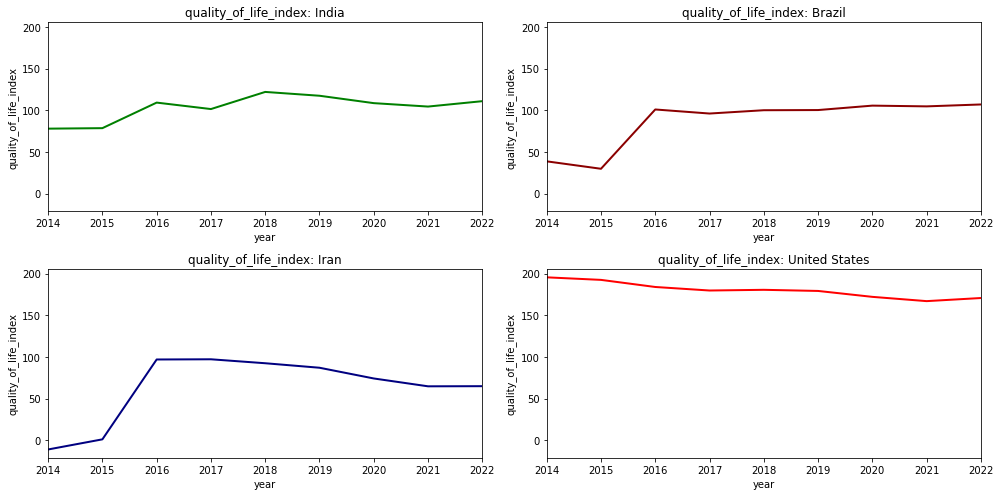

In [7]:
fig = plt.figure(figsize=(14, 7))
for i, country_name in enumerate(countries_list):
    axc = fig.add_subplot(2, 2, i + 1)
    ax = df[country_name]["quality_of_life_index"].plot(
        ax=axc, legend=False, lw=2, color=country_colors[country_name]
    )
    ax.set_title(f"quality_of_life_index: {country_name}")
    ax.set_ylabel("quality_of_life_index")
    ax.set_ylim(
        df_quality_of_life_index_stats["Min"].min() - 10,
        df_quality_of_life_index_stats["Max"].max() + 10,
    )
    ax.set_xlim(df[country_name].index.min(), df[country_name].index.max())

fig.tight_layout()

From these four graphs it is clear that quality of life index is highest in United States, followed by India. Let's plot these four line graph in a single plot to get a better understaning. 

In [8]:
def merge_data_by_column(col_name):
    columns = {country_name: df[country_name][col_name] for country_name in countries_list}

    df_merged = pd.DataFrame(columns).sort_index()
    # note if we have some mismatches on dates between cities, we will drop the rows
    return df_merged.dropna()

In [9]:
fig = go.Figure()
for country_name in countries_list:
    fig.add_trace(
        go.Scatter(
            x=df[country_name].index,
            y=df[country_name]["quality_of_life_index"],
            mode="lines+markers",
            name=country_name,
            marker_color=country_colors[country_name],
        )
    )

fig.update_layout(title_text="quality_of_life Index", barmode="group")
fig.show()

## Comparing quality_of_life_index with pollution_index

In [10]:
fig = go.Figure()
for country_name in countries_list:
    fig.add_trace(
        go.Bar(
            x=df[country_name].index,
            y=df[country_name]["pollution_index"],
            name="Pollution " + country_name,
            marker_color=country_colors[country_name],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df[country_name].index,
            y=df[country_name]["quality_of_life_index"],
            mode="lines+markers",
            name=country_name,
            marker_color=country_colors[country_name],
        )
    )

fig.update_layout(
    title_text="Quality of life Index vs Pollution Index",
    barmode="group",
    xaxis_title="Year",
)
fig.show()

We can observer that Iran has the highest pollution index and this is resulting in the lowest quality_of_life_index. Furthermore, US has least pollution thus tops up in quality_of_life_index.

If we deselect the legends of US and Iran, we see an interesting graph.
We got to know that pollution does not affect the quality_of_life_index in other cases. From the graph we can see that pollution is high in India but still has more quality_of_life_index than Brazil which has comparitively less pollution. 

This shows a negative correlation. We will drop this feature.

## Comparing quality_of_life_index with Healthcare_index

In [11]:
fig = go.Figure()
for country_name in countries_list:
    fig.add_trace(
        go.Scatter(
            x=df[country_name].index,
            y=df[country_name]["healthcare_index"],
            name="healthcare " + country_name,
            marker_color=country_colors[country_name],
        )
    )

fig.update_layout(
    title_text="Healthcare Index",
    barmode="group",
    xaxis_title="Year",
)
fig.show()

- India and US have better healthcare_index and thus gives a good quality_of_life_index.
- Iran has lowest healthcare_index and thus fails in giving a good quality_of_life_index.

This shows good positive relation. Let's check this at the end.

## Comparing quality_of_life_index with cpi_index

In [12]:
fig = go.Figure()
for country_name in countries_list:
    fig.add_trace(
        go.Bar(
            x=df[country_name].index,
            y=df[country_name]["cpi_index"],
            name="cpi_index " + country_name,
            marker_color=country_colors[country_name],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df[country_name].index,
            y=df[country_name]["quality_of_life_index"],
            mode="lines+markers",
            name=country_name,
            marker_color=country_colors[country_name],
        )
    )

fig.update_layout(
    title_text="Quality of life Index vs CPI Index", barmode="group", xaxis_title="Year"
)
fig.show()

- From the above graph we can see that cpi_index directly affects the quality_of_life_index.
- Lowest cpi_index is given by India, but results in top 2 quality_of_life_index.
- US has the highest cpi_index but still gives highest quality_of_life_index.
- Brazil shows a good trend of increasing quality_of_life_index when there is decrease in cpi_index.
- While Iran shows good sudden increase in quality_of_life_index but then linearly degrading.

It is ambiguous that quality_of_life_index is dependent on cpi_index.

## Looking at purchasing_power_incl_rent_index

In [13]:
fig = go.Figure()
for country_name in countries_list:
    fig.add_trace(
        go.Bar(
            x=df[country_name].index,
            y=df[country_name]["purchasing_power_incl_rent_index"],
            name="purchase " + country_name,
            marker_color=country_colors[country_name],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df[country_name].index,
            y=df[country_name]["quality_of_life_index"],
            mode="lines+markers",
            name=country_name,
            marker_color=country_colors[country_name],
        )
    )

fig.update_layout(
     title_text="Quality of life Index vs purchasing_power_incl_rent Index", barmode="group", xaxis_title="Year"
)
fig.show()

In [14]:
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")

for i, country_name in enumerate(countries_list):
    if i < 2:
        rrow = 1
        ccol = i + 1
    else:
        rrow = 2
        ccol = i - 1
    fig.add_trace(
        go.Scatter(
            y=df[country_name]["purchasing_power_incl_rent_index"],
            x=df[country_name]["quality_of_life_index"],
            mode="markers",
            name=country_name,
            marker_color=country_colors[country_name],
        ),
        row=rrow,
        col=ccol,
    )

fig.show()

- High purchase power in US and India gives high quality_of_life_index in US and India
- Similar trend for Iran

We can say they have positive realtions.

## Looking at quality_of_life_index overall

In [15]:
df_quality_of_life_index = merge_data_by_column("quality_of_life_index")
df_quality_of_life_index.head(5)

,India,Brazil,Iran,United States
year,,,,
2014,78.01,38.76,-11.08,195.55
2015,78.60,29.84,1.07,192.49
2016,109.28,101.02,96.93,183.96
2017,101.52,96.15,97.17,179.73
2018,122.09,100.13,92.43,180.56


In [16]:
fig = px.box(df_quality_of_life_index)
fig.show()

This gives an overall idea how quality_of_life_index is among all four countries. 
- It is to be noted that Brazil has 2 outliers which are still above than Iran's minimum quality_of_life_index.

## Checking correlations

In [17]:
df["India"].columns

Index(['country', 'traffic_time_index', 'quality_of_life_index',
       'healthcare_index', 'purchasing_power_incl_rent_index',
       'house_price_to_income_ratio', 'pollution_index', 'safety_index',
       'cpi_index'],
      dtype='object')

In [18]:
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df_corr,
        square=True,
        cbar=False,
        annot=True,
        cmap="RdYlGn",
        linewidths=0.5,
        vmin=-1,
    )
    ax.set_title(title)

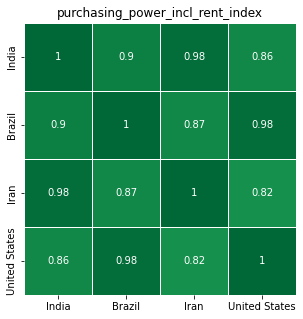

In [19]:
plot_heatmap(
    "purchasing_power_incl_rent_index",
    merge_data_by_column("purchasing_power_incl_rent_index"),
)

In terms of purchasing_power_incl_rent_index correlations, we can see a reasonable level of correlation between all countries.

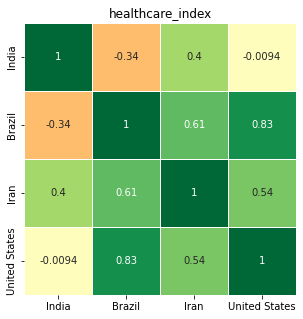

In [20]:
plot_heatmap(
    "healthcare_index",
    merge_data_by_column("healthcare_index"),
)

In terms of healthcare_index correlations, we can see a reasonable level of correlation between Brazil, Iran and United States, and less so for India. The correlation between India and the other countries is considerably lower.

Let's look into quality_of_life_index

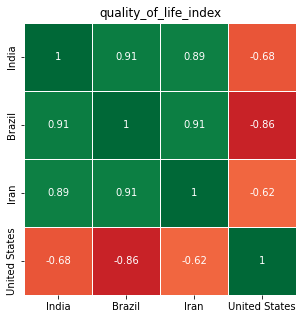

In [21]:
plot_heatmap("quality_of_life_index", merge_data_by_column("quality_of_life_index"))

In terms of quality_of_life_index correlations, we can see a reasonable level of correlation between India, Brazil and Iran, and less so for United States.

Let's look to cpi_index

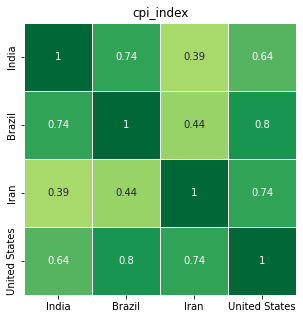

In [22]:
plot_heatmap("cpi_index", merge_data_by_column("cpi_index"))

In this case the correlations across countries are far positive.

# Correlations Between Variables

In [23]:
target_columns = [
    "quality_of_life_index",
    "healthcare_index",
    "purchasing_power_incl_rent_index",
    "safety_index",
    "cpi_index",
]

In [24]:
all_dfs = []
for country_name in countries_list:
    all_dfs.append(df[country_name].reset_index())
# concatendate all of the DataFrames into a single stacked frame
df_all = pd.concat(all_dfs)
df_all.head()

,year,country,traffic_time_index,quality_of_life_index,healthcare_index,purchasing_power_incl_rent_index,house_price_to_income_ratio,pollution_index,safety_index,cpi_index
0,2014,India,47.72,78.01,64.62,62.33,10.16,74.34,56.30,26.70
1,2015,India,45.24,78.60,66.86,65.79,10.06,77.72,53.45,26.27
2,2016,India,45.98,109.28,66.47,89.65,10.54,77.02,53.41,24.14
3,2017,India,46.38,101.52,69.18,76.73,10.28,76.53,56.04,25.08
4,2018,India,46.76,122.09,67.39,79.27,9.73,75.89,55.84,26.88


In [25]:
df_all2 = df_all[target_columns]
df_all2.head()

,quality_of_life_index,healthcare_index,purchasing_power_incl_rent_index,safety_index,cpi_index
0,78.01,64.62,62.33,56.30,26.70
1,78.60,66.86,65.79,53.45,26.27
2,109.28,66.47,89.65,53.41,24.14
3,101.52,69.18,76.73,56.04,25.08
4,122.09,67.39,79.27,55.84,26.88


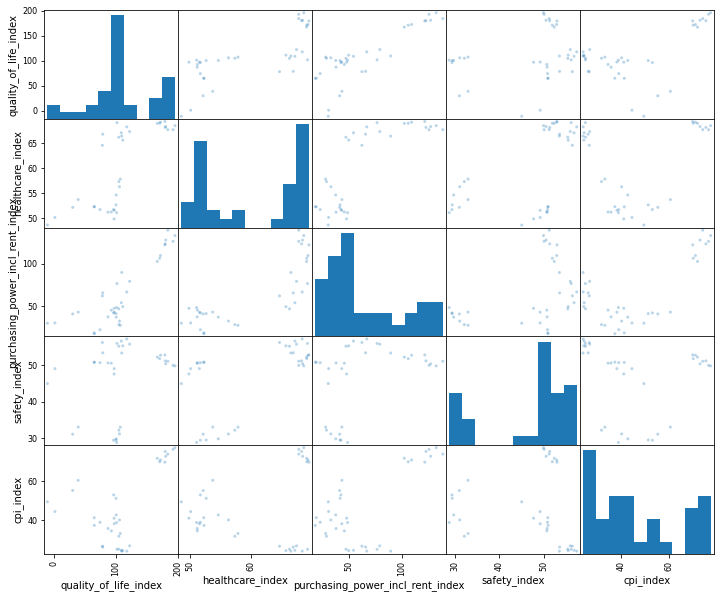

In [26]:
ax = scatter_matrix(df_all2, figsize=(12, 10), alpha=0.3)

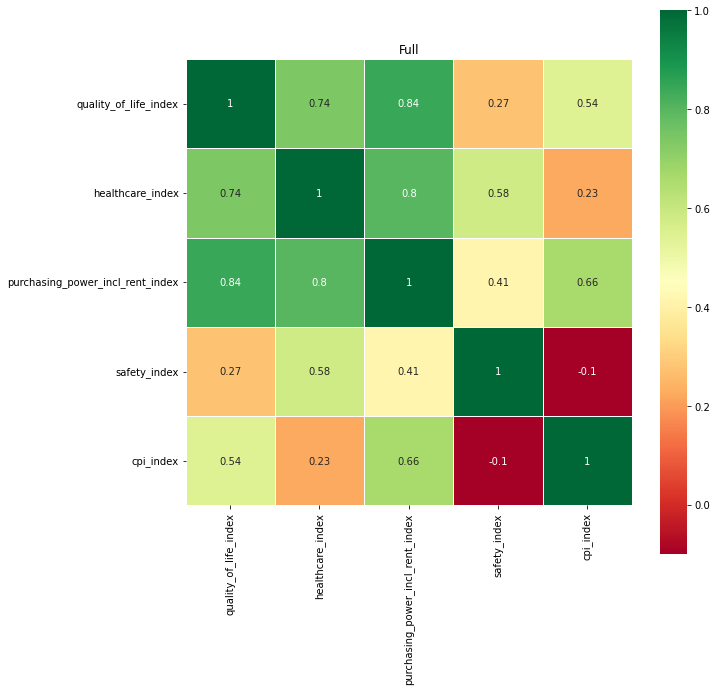

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df_all2.corr(), cmap="RdYlGn", vmax=1, annot=True, linewidth=1, square=True
).set(title="Full")
plt.show()

From the heatmap, we can see that 
- By far the strongest correlation is between quality_of_life_index and purchasing_power_incl_rent_index. 
- Second strongest correlation is between purchasing_power_incl_rent_index and healthcare_index.
- Third strongest correlation is between quality_of_life_index and healthcare_index. 
- In contrast, safety_index is quite strongly negatively correlated with cpi_index, although it does correspond to healthcare_index.

## Ploting two highly correlated features

In [28]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_all2["purchasing_power_incl_rent_index"],
        y=df_all2["quality_of_life_index"],
        mode="markers",
    )
)

fig.update_layout(
    title_text="Overall Quality of life Index vs purchasing_power_incl_rent Index",
    xaxis_title="Healthcare",
    yaxis_title="Quality of life",
)
fig.show()

# Conclusion

In this assignment we looked at the analysis of yearly data for four countries, focusing particularly on quality_of_life_index, healthcare_index, purchasing_power_incl_rent_index, safety_index and cpi_index.

We can conclude from the above graphs that US is least similar to India, Iran and Brazil in terms of quality_of_life_index.

India, Iran and Brazil are very similar in terms of quality_of_life_index.

- quality_of_life_index and purchasing_power_incl_rent_index heavily depend on each other
- purchasing_power_incl_rent_index and healthcare_index also depend on each other
- quality_of_life_index and healthcare_index are intransitive.
- safety_index is quite strongly negatively correlated with cpi_index, although it does correspond to healthcare_index.


Some restriction of using Numbeo API:
- It is not available free of cost. I had to contact the support to provide me a free access for educational work for 60 days.
- Histrorical data is not present for years before 2014.

# Future Work

Further this dataset can be used to generate a machine learning model that can classify the data into countries or can predict the quality_of_life_index for a given healthcare_index, purchasing_power_incl_rent_index, safety_index, cpi_index.

There are many other sections available in API which can be explored and analyzed.
- section=1	Cost of Living
- section=2	Property Prices
- section=4	Traffic
- section=7	Crime
- section=8	Pollution